# Gaussian SMC Sampler
this is a simple model for an SMC Sampler


In [1]:
from melange_lite.melange_lite import GaussianSMCSamplerFactory

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Test the Factory
I am going to tease apart the factory to make sure it works as I would expect

In [3]:
from melange_lite.utils.gaussians import *
from jax import random

In [4]:
T=50
start_mu, end_mu=0., 5.
gaussian_cov = jnp.log(jnp.ones(T)[..., jnp.newaxis])
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis]

In [5]:
IW_parameters = {'mu': mus, 'lcov_force': gaussian_cov}

In [6]:
gsmc_factory = GaussianSMCSamplerFactory(T=50, N=500, IW_parameters=IW_parameters)

In [7]:
M_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
               'lcov_force': jnp.zeros((T-1,1))}
L_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
               'lcov_force': jnp.zeros((T-1,1))}

In [8]:
params = {'mu': jnp.array([0.]),
         'lcov': jnp.log(jnp.array([1.])),
         'seed': random.PRNGKey(32),
         'M_parameters': M_parameters,
         'L_parameters': L_parameters,
         'ldt': jnp.log(1e-2)
         }

In [9]:
init_xs = gsmc_factory.M0(params)

In [10]:
init_xs['x'].shape

(500, 1)

(array([  3.,   9.,  25.,  54.,  95., 124.,  93.,  65.,  23.,   9.]),
 array([-3.25966758, -2.65249432, -2.04532106, -1.4381478 , -0.83097454,
        -0.22380129,  0.38337197,  0.99054523,  1.59771849,  2.20489175,
         2.81206501]),
 <BarContainer object of 10 artists>)

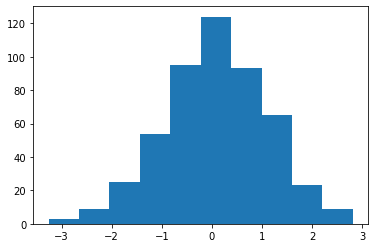

In [11]:
plt.hist(init_xs['x'].flatten())

In [12]:
np.var(init_xs['x'].flatten())

DeviceArray(1.06198702, dtype=float64)

cool, now let's run the smc sampler...

In [13]:
xps = init_xs
xs = gsmc_factory.M(xps, params, 0)

In [14]:
lws = gsmc_factory.logG(xps, xs, params, 0)

In [15]:
work_fn = gsmc_factory.works()

In [16]:
works = work_fn(params)

(array([ 2.,  0.,  3.,  1.,  4.,  1.,  6.,  9., 12.,  8., 10., 18., 17.,
        11., 24., 16., 23., 24., 22., 20., 32., 28., 23., 20., 24., 21.,
        25., 16.,  9., 15., 14., 10.,  4.,  5.,  5.,  6.,  5.,  4.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.83196507, -1.19471942, -0.55747377,  0.07977188,  0.71701753,
         1.35426318,  1.99150883,  2.62875448,  3.26600013,  3.90324578,
         4.54049143,  5.17773708,  5.81498273,  6.45222839,  7.08947404,
         7.72671969,  8.36396534,  9.00121099,  9.63845664, 10.27570229,
        10.91294794, 11.55019359, 12.18743924, 12.82468489, 13.46193054,
        14.09917619, 14.73642185, 15.3736675 , 16.01091315, 16.6481588 ,
        17.28540445, 17.9226501 , 18.55989575, 19.1971414 , 19.83438705,
        20.4716327 , 21.10887835, 21.746124  , 22.38336965, 23.0206153 ,
        23.65786096, 24.29510661, 24.93235226, 25.56959791, 26.20684356,
        26.84408921, 27.48133486, 28.11858051, 28.75582616,

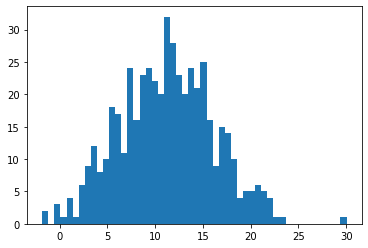

In [17]:
plt.hist(works, bins=50)

and that looks like a legit work distribution...

todo: 
- compute free energy
- check to make sure indexing is being carried out properly
- run smc with different lengths to show that it improves with longer annealing time
- check to see that we can take grad w.r.t. necessary forward propagation parameters.
- take grad and demonstrate that vsmc works (again)
- flip all of the parameters and do it in reverse...
- compute BAR estimator...
-take grad in forward and backward direction likewise!!!!

free energy

In [18]:
def f(cum_works):
    """
    compute a free energy from cumulative works
    """
    from jax.scipy.special import logsumexp
    N = len(cum_works)
    logZ = logsumexp(-cum_works) - jnp.log(N)
    return -logZ

done:
- compute free energy
- check to make sure indexing is being carried out properly (this was done manually, but i think it is right)

In [19]:
f(works)

DeviceArray(3.28620189, dtype=float64)

can we do the same with longer annealing time?

In [20]:
start_mu, end_mu=0., 5.
N=248
f_collector = []
import tqdm
from jax import jit, value_and_grad
times = [10,50,100,500, 1000, 5000]
seed = random.PRNGKey(35)
for i in tqdm.trange(len(times)):
    T = times[i]
    
    #define gaussian cov and mu cov
    start_mu, end_mu=0., 5.
    gaussian_cov = jnp.log(jnp.ones(T)[..., jnp.newaxis])
    mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis]
    IW_parameters = {'mu': mus, 'lcov_force': gaussian_cov}
    
    # define the forward and backward parameters
    M_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
               'lcov_force': jnp.zeros((T-1,1))}
    L_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
               'lcov_force': jnp.zeros((T-1,1))}
    
    # put them all together...
    params = {'mu': jnp.array([0.]),
         'lcov': jnp.log(jnp.array([1.])),
         'seed': seed,
         'M_parameters': M_parameters,
         'L_parameters': L_parameters,
         'ldt': jnp.log(1e-2)
         }
    
    #make the factory...
    factory = GaussianSMCSamplerFactory(T=T, 
                                        N=N, 
                                        IW_parameters=IW_parameters)
    
    works_fn = jit(factory.works())
    fs = []
    for i in range(100):
        old_seed = params['seed']
        params['seed'] = random.split(old_seed)
        works = works_fn(params)
        fs.append(f(works))
    f_collector.append(fs)
    
    
    
    
    
    

100%|██████████| 6/6 [00:31<00:00,  5.20s/it]


In [21]:
f_collector = np.array(f_collector)

In [22]:
f_collector.shape

(6, 100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0be012c0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0c4076c6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0be04d0b90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0bc8190950>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0bc81a3b10>,
 'means': []}

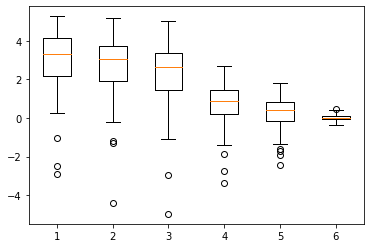

In [23]:
plt.boxplot(np.transpose(f_collector))

consider the case where we have $N=10$ particles and $T=50$. we want to take the gradient w.r.t. forward parameters. can we do that?


In [37]:
N=10
T=248

start_mu, end_mu=0., 5.
gaussian_cov = jnp.log(jnp.ones(T)[..., jnp.newaxis])
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis]
IW_parameters = {'mu': mus, 'lcov_force': gaussian_cov}

factory = GaussianSMCSamplerFactory(T=T, 
                                    N=N, 
                                    IW_parameters=IW_parameters)

work_fn = factory.works()

M_parameters = {'lcov_force': jnp.zeros((T-1,1))}
L_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
           'lcov_force': jnp.zeros((T-1,1))}

params = {'mu': jnp.array([0.]),
     'lcov': jnp.log(jnp.array([1.])),
     'seed': seed,
     'M_parameters': M_parameters,
     'L_parameters': L_parameters,
     'ldt': jnp.log(1e-2)
     }

def f_estimator(mus, seed):
    params['M_parameters']['mu'] = mus
    params['seed'] = seed
    works = work_fn(params)
    free_energy = f(works)
    return free_energy

    
valgrad_f_estimator = jit(value_and_grad(f_estimator))  



In [38]:
f_estimator(jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:], random.PRNGKey(234))

DeviceArray(6.41813416, dtype=float64)

In [39]:
outs_ = valgrad_f_estimator(jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:], random.PRNGKey(234))

so taking the grad works...

what happens if we try to take the grad many times??

In [40]:
fs = []
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:]
seed = random.PRNGKey(324)
lr=5e-1
for i in tqdm.trange(5000):
    run_seed, seed = random.split(seed)
    f_val, gradval = valgrad_f_estimator(mus, run_seed)
    mus = mus - lr*gradval
    fs.append(f_val)
    
    
    
    

100%|██████████| 5000/5000 [00:02<00:00, 1704.79it/s]


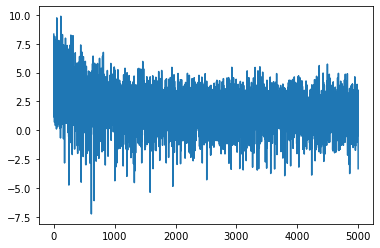

In [41]:
plt.plot(fs)

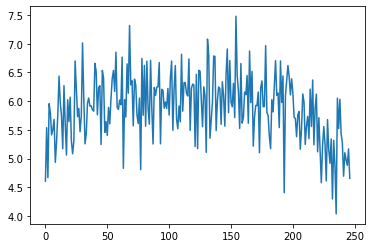

In [42]:
plt.plot(mus)

great, can we now also modify the width of the potential?!

In [43]:
N=10
T=500

start_mu, end_mu=0., 5.
gaussian_cov = jnp.log(jnp.ones(T)[..., jnp.newaxis])
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis]
IW_parameters = {'mu': mus, 'lcov_force': gaussian_cov}

factory = GaussianSMCSamplerFactory(T=T, 
                                    N=N, 
                                    IW_parameters=IW_parameters)

work_fn = factory.works()

M_parameters = {}
L_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
           'lcov_force': jnp.zeros((T-1,1))}

params = {'mu': jnp.array([0.]),
     'lcov': jnp.log(jnp.array([1.])),
     'seed': seed,
     'M_parameters': M_parameters,
     'L_parameters': L_parameters,
     'ldt': jnp.log(1e-2)
     }

def f_estimator(mu_lcov_dict, seed):
    params['M_parameters']['mu'] = mu_lcov_dict['mu']
    params['M_parameters']['lcov_force'] = mu_lcov_dict['lcov_force']
    params['seed'] = seed
    works = work_fn(params)
    free_energy = f(works)
    return free_energy

    
valgrad_f_estimator = jit(value_and_grad(f_estimator))  



In [44]:
in_dict = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
           'lcov_force': jnp.zeros((T-1,1))
          }
f_estimator(in_dict, random.PRNGKey(234))

DeviceArray(1.59352498, dtype=float64)

In [45]:
jf, jgrad = valgrad_f_estimator(in_dict, random.PRNGKey(234))

In [46]:
fs = []
in_dict = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
           'lcov_force': jnp.zeros((T-1,1))
          }
seed = random.PRNGKey(3454)
lr=1e-1
for i in tqdm.trange(15000):
    run_seed, seed = random.split(seed)
    f_val, gradval = valgrad_f_estimator(in_dict, run_seed)
    in_dict['mu'] = in_dict['mu'] - lr*gradval['mu']
    in_dict['lcov_force'] = in_dict['lcov_force'] - lr*gradval['lcov_force']
    
    fs.append(f_val)

100%|██████████| 15000/15000 [00:20<00:00, 747.77it/s]


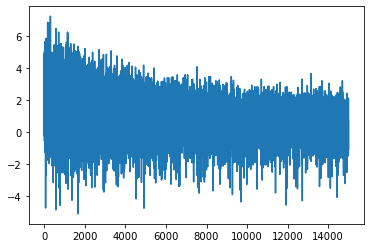

In [47]:
plt.plot(fs)

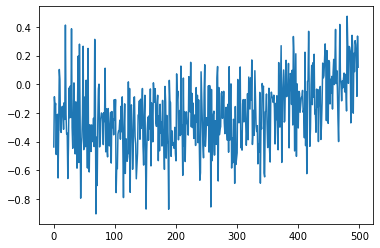

In [48]:
plt.plot(in_dict['lcov_force'])

so it seems like that also shows an improvement, but converges more slowly.

now, I'll try to go back to the original case where we can change the values of $\mu$ in the force object, sample without training, train, and then sample again to show the relative gain in accuracy and reduction in bias...

In [49]:
N=10
T=248

start_mu, end_mu=0., 5.
gaussian_cov = jnp.log(jnp.ones(T)[..., jnp.newaxis])
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis]
IW_parameters = {'mu': mus, 'lcov_force': gaussian_cov}

factory = GaussianSMCSamplerFactory(T=T, 
                                    N=N, 
                                    IW_parameters=IW_parameters)

work_fn = factory.works()

M_parameters = {'lcov_force': jnp.zeros((T-1,1))}
L_parameters = {'mu': jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:],
           'lcov_force': jnp.zeros((T-1,1))}

params = {'mu': jnp.array([0.]),
     'lcov': jnp.log(jnp.array([1.])),
     'seed': seed,
     'M_parameters': M_parameters,
     'L_parameters': L_parameters,
     'ldt': jnp.log(1e-2)
     }

@jit
def f_estimator(mus, seed):
    params['M_parameters']['mu'] = mus
    params['seed'] = seed
    works = work_fn(params)
    free_energy = f(works)
    return free_energy

    
valgrad_f_estimator = jit(value_and_grad(f_estimator))  



In [50]:
untrained_fs = []
mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:]
seed = random.PRNGKey(667)
for i in tqdm.trange(1000):
    seed, run_seed = random.split(seed)
    f_val = f_estimator(mus, run_seed)
    untrained_fs.append(f_val)
    
    

100%|██████████| 1000/1000 [00:01<00:00, 547.55it/s]


/home/dominic/anaconda3/envs/melange/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

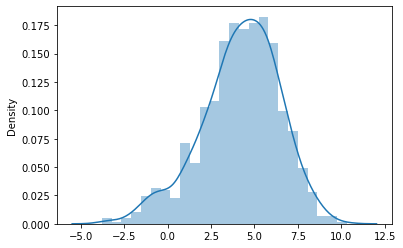

In [51]:
sns.distplot(untrained_fs)

In [52]:
training_fs = []
training_mus = jnp.linspace(start_mu, end_mu, T)[..., jnp.newaxis][1:]
lr=5e-1
for i in tqdm.trange(10000):
    run_seed, seed = random.split(seed)
    f_val, gradval = valgrad_f_estimator(training_mus, run_seed)
    training_mus = training_mus - lr*gradval
    training_fs.append(f_val)

100%|██████████| 10000/10000 [00:09<00:00, 1078.52it/s]


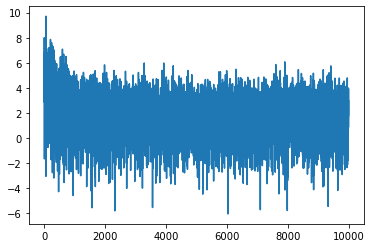

In [53]:
plt.plot(training_fs)

In [54]:
trained_fs = []
for i in tqdm.trange(1000):
    seed, run_seed = random.split(seed)
    f_val = f_estimator(training_mus, run_seed)
    trained_fs.append(f_val)

100%|██████████| 1000/1000 [00:00<00:00, 2061.40it/s]


/home/dominic/anaconda3/envs/melange/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dominic/anaconda3/envs/melange/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'estimated free energy [kT]')

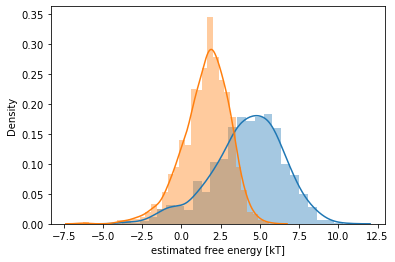

In [55]:
sns.distplot(untrained_fs, label=f"pre-training")
sns.distplot(trained_fs, label=f"post_training")
plt.xlabel("estimated free energy [kT]")

This looks great!
TODO in another notebook:
- implement BAR in the near-reversible regime
- train the forward pass, flip, and without training backward, compute BAR estimate
- train forward/backward passes simultaneously.
